In [1]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download codingnirvana/captcha-images
# ! unzip captcha-images.zip

In [2]:
# ! unrar x images.rar /content

In [3]:
import pandas as pd 
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


df = pd.read_csv('/content/trainLabels.csv',names=['id','captcha'])
df.head()

,id,captcha
0,1,GLPCUN
1,3,CHJKUU
2,7,PCUAKC
3,8,UHGFHA
4,10,BUYPAT


In [4]:
df[df['id'] ==  1]['captcha']

0    GLPCUN
Name: captcha, dtype: object

In [5]:
cv2.imread('/content/train/100').shape

(70, 200, 3)

In [6]:
alphabet = {
        'A' : 0, 
        'B' : 1, 
        'C' : 2, 
        'D' : 3, 
        'E' : 4, 
        'F' : 5, 
        'G' : 6, 
        'H' : 7, 
        'I' : 8, 
        'J' : 9, 
        'K' : 10, 
        'L' : 11, 
        'M' : 12, 
        'N' : 13, 
        'O' : 14, 
        'P' : 15, 
        'Q' : 16, 
        'R' : 17, 
        'S' : 18, 
        'T' : 19, 
        'U' : 20, 
        'V' : 21, 
        'W' : 22, 
        'X' : 23, 
        'Y' : 24, 
        'Z' : 25
    }

In [7]:
def Create_train_dataset():
  
  images = os.listdir('/content/train')

  x = []
  y = []

  for image in images:

    if image == "data":
      continue

    x.append(cv2.cvtColor(cv2.imread(f'/content/train/{image}'),cv2.COLOR_BGR2GRAY))
    
    string = df[df['id'] ==  int(image)]['captcha'].values[0]
    
    chars = []
    
    for char in string:
      chars.append(alphabet[char])        

    y.append(chars)

  return np.array(x) ,np.array(y)

def Create_test_dataset():
  
  images = os.listdir('/content/test')

  x = []
  
  for image in images:

    if image == "data":
      continue

    x.append(cv2.cvtColor(cv2.imread(f'/content/test/{image}'),cv2.COLOR_BGR2GRAY))

  return np.array(x) 

In [8]:
def create_train_dataset2():
  
  images = os.listdir('/content/images')

  x = []
  y = []

  for image in images :
    # print(image)

    x.append(cv2.cvtColor(cv2.imread(f'/content/images/{image}'),cv2.COLOR_BGR2GRAY))
    string = image[0:6]

    indexes = []

    for char in string:

      indexes.append(alphabet[char])
    
    y.append(indexes)

  return np.array(x) , np.array(y)

In [9]:
def create_model():


  X = tf.keras.layers.Input(shape=(70,200,1),batch_size=None,name="input_layer")

  conv_1 = tf.keras.layers.Conv2D(16,(3,3))(X)

  max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(3,3))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(32,(3,3))(max_pool_1)

  max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(32,(3,3))(max_pool_2)

  bn = tf.keras.layers.BatchNormalization()(conv_3)

  max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(3,3))(bn)

  flattened = tf.keras.layers.Flatten()(max_pool_3)

  outs = []

  for _ in range(6):
    dens1 = tf.keras.layers.Dense(64, activation='relu')(flattened)
    drop = tf.keras.layers.Dropout(0.5)(dens1)
    res = tf.keras.layers.Dense(26,activation='softmax')(drop)
    outs.append(res)

  model = tf.keras.Model(X, outs)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

  model.summary()

  return model

In [10]:
num_to_char = {value:key for key , value in alphabet.items() }

In [11]:
def predict(img):
  
  prediction = model.predict(img.reshape(1,70,200,1))
  word = ""
  for i in range(len(prediction)):
    word += num_to_char[np.argmax(prediction[i])]

  return word

In [12]:
x_train,y_train = Create_train_dataset()
x_train.shape,y_train.shape

((200, 70, 200), (200, 6))

In [13]:
X_train2 , y_train2 = create_train_dataset2()
X_train2.shape , y_train2.shape

((708, 70, 200), (708, 6))

In [14]:
x_train = np.concatenate((x_train,X_train2))
x_train.shape

(908, 70, 200)

In [15]:
y_train = np.concatenate((y_train,y_train2))
y_train.shape

(908, 6)

In [16]:
X_test = Create_test_dataset()

In [17]:
X_test.shape

(176, 70, 200)

In [18]:
model = create_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 70, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 198, 16)  160         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 22, 66, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 64, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
model.fit(x=x_train.reshape(908, 70, 200,1) ,y=[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4],y_train[:,5]],epochs=1000)

'UYBBNR'

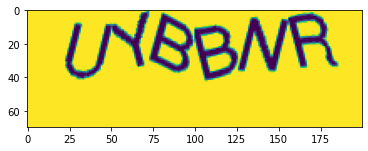

In [20]:
plt.imshow(X_test[0])
predict(X_test[0])

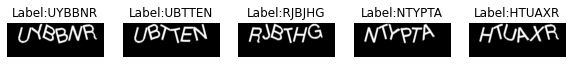

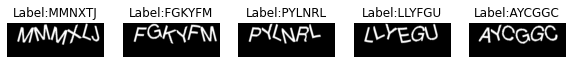

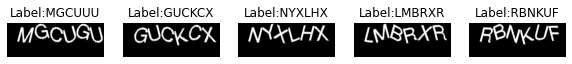

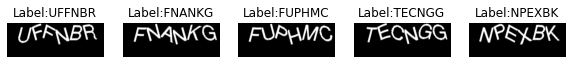

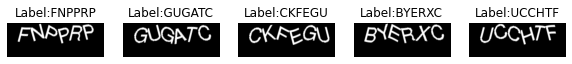

In [23]:
# plt.imshow(X_test[0])
# predict(X_test[0])

n_samples = 5
for i in range(5):
  plt.figure(figsize=(n_samples * 2, 3))
  for index in range(n_samples):
      plt.subplot(1, n_samples, index + 1)
      plt.imshow(X_test[index+5*i], cmap="binary")
      plt.title("Label:" + predict(X_test[index+5*i]))
      plt.axis("off")

  plt.show()


In [25]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


In [27]:
model_json = model.to_json()
with open("/content/model_json/captcha.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/model_json/captcha.h5")